Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Содержание проекта
___
1. Общее выполнение кода занимает ~30 минут, поэтому гиперпараметры моделей, в частости lgbm подбирались вручную, а не через цикл.
1. Кроме того Kernel переодически умирает, но при некоторых перезагрузках считает и удается получить результат
1. Модель Bert пробовал, но выходит ошибка, что токинизированные значения выходят за рамки 512 максимально возможных...


[Шаг 1: подготовка данных](#step1)
- [1.1.Импорт библиотек](#step1_1)
- [1.2. Изучаем изначальные данные](#step1_2)
- [1.3. Пишем функции для предобработки текстов](#step1_3)
- [1.4. Разделяем на выборки](#step1_4)
- [1.5. Собираем мешок слов](#step1_5)
- [1.6. Проводим TF-IDF векторизацию](#step1_6)
- [1.7. Задаем модели для прогнозирования: линейная регрессия, решающее дерево и lgbm](#step1_7) 
 
[Шаг 2: обучение моделей](#step2)
- [2.1. Линейная регрессия](#step2_1)
- [2.2. Решающее дерево](#step2_2)
- [2.3. lgbm](#step2_3)

[Шаг 3: анализ моделей и выводы](#step3)

<a id='step1'></a>

# 1. Подготовка

<a id='step1_1'></a>

## 1.1. Загрузим библиотеки проекта

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

from lightgbm import LGBMClassifier

<a id='step1_2'></a>

## 1.2. Загрузим и оценим данные

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3900b82d10>],
      dtype=object)

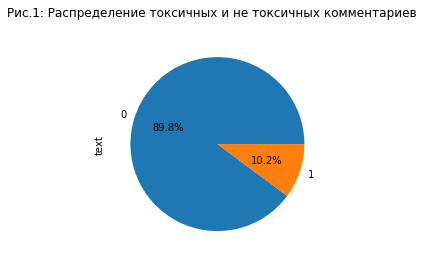

In [4]:
data.pivot_table(index='toxic', values='text', aggfunc='count').plot(kind='pie', 
                                                                     subplots=True, 
                                                                     autopct='%1.1f%%', 
                                                                     legend=False,
                                                                     title='Рис.1: Распределение токсичных и не токсичных комментариев')

In [5]:
print("Примеры токсичных комментариев")
display(data.query('toxic == 1').head())

Примеры токсичных комментариев


,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


In [6]:
print("Примеры не токсичных комментариев")
display(data.query('toxic == 0').head())

Примеры не токсичных комментариев


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


__Промежуточный комментарий:__
___
1. 159571 наблюдений в исходном дата-сете из которых только ~10% это токсичные комментарии, а оставшиеся не токсичные.
2. Две таблицы-среза выше показывают глубину токсичности - ненормативная лексика и угрозы, крайне токсично... ☢️

<a id='step1_3'></a>

## 1.3. Напишем и применим функции для предобработки текста
___
Так чтобы остались только латинские буквы

In [7]:
lemmatizer = WordNetLemmatizer()

def clear_text(text):
    result = " ".join((re.sub(r'[^a-zA-Z]', ' ', text)).split())
    return(result)

In [8]:
%%time
data['lem_text'] = data['text'].apply(lemmatizer.lemmatize).apply(clear_text)

CPU times: user 14 s, sys: 353 ms, total: 14.3 s
Wall time: 14.4 s


<a id='step1_4'></a>

## 1.4. Разделяем выборку на обучающую и тестовую

In [9]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state = 12345)

In [10]:
data_train = data_train.drop(columns='text', axis =1)
data_test = data_test.drop(columns='text', axis =1)

<a id='step1_5'></a>

## 1.5. Соберем "мешок-слов" из лемматезированных комментариев

In [11]:
stopwords = set(nltk_stopwords.words('english'))

In [12]:
corpus_train = data_train['lem_text'].values.astype('U')

In [ ]:
corpus_test = data_test['lem_text'].values.astype('U')

In [ ]:
count_vect = CountVectorizer(stop_words=stopwords, ngram_range=(1, 1))

In [ ]:
%%time
bow_train = count_vect.fit_transform(corpus_train)
bow_test = count_vect.transform(corpus_test)

<a id='step1_6'></a>

## 1.6. Проведем TF-IDF векторизацию лемматизированных ранее комментариев

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range = (1,1)) 

In [ ]:
count_tf_idf.fit(corpus_train)

In [ ]:
tf_idf_train = count_tf_idf.transform(corpus_train)

In [ ]:
tf_idf_test = count_tf_idf.transform(corpus_test)

<a id='step1_7'></a>

## 1.7. Определим модели которые будем использовать для обучения

In [ ]:
model_LR = LogisticRegression(class_weight='balanced', random_state=12345)

In [ ]:
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')

In [ ]:
model_lgbm = LGBMClassifier()

params = {
    'learning_rate': 0.05,
    'num_class': 1,
    'num_iteration': 2000, #1000
    'num_leaves': 10,
    'max_depth': 5, 
    'n_estimators': 20, #30
    'bagging_fraction': 0.7, #0.9
    'bagging_freq': 20, #10
    'n_jobs': -1 
    }

model_lgbm.set_params(**params) 

<a id='step2'></a>

# 2. Обучение

<a id='step2_1'></a>

## 2.1. Модель линейной регрессии

__Обучение на "мешке слов"__

In [ ]:
%%time
model_LR.fit(bow_train,data_train['toxic'])
predictions_LR_bow = model_LR.predict(bow_test)

In [ ]:
print("f1 модели линейной регрессии на мешке слов:", f1_score(data_test['toxic'], predictions_LR_bow))

__Обучение на TF-IDF векторизации__

In [ ]:
%%time
model_LR.fit(tf_idf_train, data_train['toxic'])
predictions_LR_tf = model_LR.predict(tf_idf_test)

In [ ]:
print("f1 модели линейной регрессии на TF-IDF:", f1_score(data_test['toxic'], predictions_LR_tf))

__Промежуточный комментарий:__
___
Обучение на "мешке слов" дает f1 метрику хуже, а также занимает больше времени, чем при обучении на tf-idf, далее используем только обучение на tf-idf.

<a id='step2_2'></a>

## 2.2. Модель решающего дерева

In [ ]:
%%time
model_tree.fit(tf_idf_train, data_train['toxic'])

In [ ]:
%%time
predictions_tree = model_tree.predict(tf_idf_test)

In [ ]:
print("f1 модели решающего дерева:", f1_score(data_test['toxic'], predictions_tree))

<a id='step2_3'></a>

## 2.3. Модель lgbm

In [ ]:
%%time
model_lgbm.fit(tf_idf_train, data_train['toxic'])

In [ ]:
%%time
predictions_lgbm = model_lgbm.predict(tf_idf_test)

In [ ]:
print("f1 модели lgmb:", f1_score(data_test['toxic'], predictions_lgbm))

<a id='step3'></a>

# 3. Выводы

Мы обучили 3 модели прогноза классификации комментариев на "токсичные"/"не токсичные":
1. модель линейной регрессии. f1 на tf-idf: 0.75 (f1 на мешке слов: 0.74) = целевому 0.75
1. модель случайного дерева. f1: 0.43
1. модель lgbm. f1: 0.78 - выше целевого 0.75

Использованные параметры:
1. Обучающая выборка 75%, тестовая 25%
1. Сбалансированные модели
1. Мы не использовали би-граммы и три-граммы, но предусмотрели для этого место в коде. При использовании би-грамм например юпитер "падает". Интуитивно нам важны любые нецензурные слова, а не слово сочетания, поэтому моно-граммы для задачи считаю, что подходят.